In [1]:
import cv2
import torch.hub
import os
import model
from PIL import Image
from torchvision import transforms
from grad_cam import BackPropagation
import time 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython import display
import threading
import vlc

#import smbus
#import requests
#from twilio.rest import Client
#import urllib.request
#import json

# Alarm sound file
file = 'alarm.mp3'
# Sound player start
p = vlc.MediaPlayer("alarm.mp3")

timebasedrow= time.time()
timebasedis= time.time()
timerundrow= time.time()
timerundis= time.time()

face_cascade = cv2.CascadeClassifier('haar_models/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('haar_models/haarcascade_eye.xml') 
MyModel="BlinkModel.t7"

shape = (24,24)
classes = [
    'Close',
    'Open',
]

eyess=[]
cface=0

In [2]:
def preprocess(image_path):
    global cface
    transform_test = transforms.Compose([
        transforms.ToTensor()
    ])
    image = cv2.imread(image_path['path'])    
    faces = face_cascade.detectMultiScale(
        image,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(1, 1),
        flags=cv2.CASCADE_SCALE_IMAGE
    )
    if len(faces) == 0:
        ...
    else:
        cface=1
        (x, y, w, h) = faces[0]
        face = image[y:y + h, x:x + w]
        cv2.rectangle(image,(x,y),(x+w,y+h),(255,255,0),2)
        roi_color = image[y:y+h, x:x+w]
        """
        Depending on the quality of your camera, this number can vary 
        between 10 and 40, since this is the "sensitivity" to detect the eyes.
        """
        sensi=20
        eyes = eye_cascade.detectMultiScale(face,1.3, sensi) 
        i=0
        for (ex,ey,ew,eh) in eyes:
            (x, y, w, h) = eyes[i]
            cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
            eye = face[y:y + h, x:x + w]
            eye = cv2.resize(eye, shape)
            eyess.append([transform_test(Image.fromarray(eye).convert('L')), eye, cv2.resize(face, (48,48))])
            i=i+1
    cv2.imwrite('temp-images/display.jpg',image) 
    

def eye_status(image, name, net):
    img = torch.stack([image[name]])
    bp = BackPropagation(model=net)
    probs, ids = bp.forward(img)
    actual_status = ids[:, 0]
    prob = probs.data[:, 0]
    if actual_status == 0:
        prob = probs.data[:,1]

    #print(name,classes[actual_status.data], probs.data[:,0] * 100)
    return classes[actual_status.data]

def func(imag,modl):
    drow(images=[{'path': imag, 'eye': (0,0,0,0)}],model_name=modl)

def drow(images, model_name):
    global eyess
    global cface
    global timebasedrow
    global timebasedis
    global timerundrow
    global timerundis
    net = model.Model(num_classes=len(classes))
    checkpoint = torch.load(os.path.join('model', model_name), map_location=torch.device('cpu'))
    net.load_state_dict(checkpoint['net'])
    net.eval()
    
    flag =1
    status=""
    for i, image in enumerate(images):
        if(flag):
            preprocess(image)
            flag=0
        if cface==0:
            image = cv2.imread("temp-images/display.jpg")
            image = cv2.putText(image, 'No face Detected', (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
            cv2.imwrite('temp-images/display.jpg',image)
            timebasedrow= time.time()
            timebasedis= time.time()
            timerundrow= time.time()
            timerundis= time.time()
        elif(len(eyess)!=0):
            eye, eye_raw , face = eyess[i]
            image['eye'] = eye
            image['raw'] = eye_raw
            image['face'] = face
            timebasedrow= time.time()
            timerundrow= time.time()
            for index, image in enumerate(images):
                status = eye_status(image, 'eye', net)
                if(status =="Close"):
                    timerundis= time.time()
                    if((timerundis-timebasedis)>1.5):
                        image = cv2.imread("temp-images/display.jpg")
                        image = cv2.putText(image, 'Distracted', (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
                        cv2.imwrite('temp-images/display.jpg',image)
                        if(not(p.is_playing())):
                            p.play()
                else:
                    p.stop()        
        else:
            timerundrow= time.time()
            if((timerundrow-timebasedrow)>3):
                if(not(p.is_playing())):
                    p.play()
                image = cv2.imread("temp-images/display.jpg")
                image = cv2.putText(image, 'Drowsy', (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
                cv2.imwrite('temp-images/display.jpg',image)

In [3]:
def main():
    while 1:
        global eyess
        global cface    
        eyess=[]
        cface=0
        ret, img = cap.read() 
        cv2.imwrite('img.jpg',img) 
        func('img.jpg',MyModel)
    
def disp():
    while 1:
        try:
            img=mpimg.imread('temp-images/display.jpg')
            plt.imshow(img)
            display.clear_output(wait=True)
            display.display(plt.gcf())
        except:
            ...

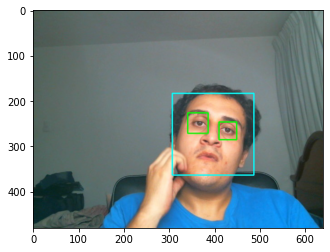

In [4]:
cap = cv2.VideoCapture(0)
timebasedrow= time.time()
timebasedis= time.time()
timerundrow= time.time()
timerundis= time.time()
        
d = threading.Thread(target=disp, name='disp')
m = threading.Thread(target=main, name='main')

d.start()
m.start()